# Unit13_Stacking_Regression | Stacking 堆疊法回歸應用

本 Notebook 使用模擬的化工反應器數據建立 Stacking 回歸模型來預測反應器出口溫度。

## 目標
- 理解 Stacking 的完整訓練流程
- 比較不同基礎模型的性能
- 評估 Stacking 相對於單一模型的改進
- 學習超參數調整策略
- 視覺化模型預測結果

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit13_Stacking_Regression'
SOURCE_DATA_DIR = 'no_data_folder'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit13'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\data\no_data_folder
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Regression
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Regression\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Regression\figs


---
## 1. 載入相關套件

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Base models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Stacking
from sklearn.ensemble import StackingRegressor

# Model persistence
import joblib
import json

# Visualization settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ All packages loaded successfully")

✓ All packages loaded successfully


---
## 2. 生成化工反應器模擬數據

模擬化學反應器的操作數據，預測反應器出口溫度。

**特徵說明：**
- `flow_rate`: 進料流量 (L/min)
- `inlet_temp`: 進料溫度 (°C)
- `concentration`: 反應物濃度 (mol/L)
- `pressure`: 反應壓力 (bar)
- `catalyst_age`: 催化劑使用時間 (hours)
- `stirring_speed`: 攪拌速度 (rpm)
- `residence_time`: 停留時間 (min)

**目標變數：**
- `outlet_temp`: 反應器出口溫度 (°C)

In [3]:
# Generate synthetic reactor data
np.random.seed(RANDOM_STATE)
n_samples = 1000

# Feature generation
flow_rate = np.random.uniform(10, 50, n_samples)
inlet_temp = np.random.uniform(50, 100, n_samples)
concentration = np.random.uniform(0.5, 2.0, n_samples)
pressure = np.random.uniform(1, 5, n_samples)
catalyst_age = np.random.uniform(0, 1000, n_samples)
stirring_speed = np.random.uniform(100, 500, n_samples)
residence_time = np.random.uniform(5, 30, n_samples)

# Complex relationship for outlet temperature
# Linear components
linear_component = (
    0.8 * inlet_temp +
    2.0 * concentration +
    5.0 * pressure -
    0.01 * catalyst_age
)

# Non-linear components
nonlinear_component = (
    0.05 * flow_rate * concentration +  # Interaction
    0.002 * stirring_speed ** 1.5 +     # Non-linear
    np.sin(residence_time / 5) * 10 +   # Periodic
    -0.0001 * catalyst_age ** 2         # Degradation
)

# Random noise
noise = np.random.normal(0, 5, n_samples)

# Target variable
outlet_temp = 100 + linear_component + nonlinear_component + noise

# Create DataFrame
df = pd.DataFrame({
    'flow_rate': flow_rate,
    'inlet_temp': inlet_temp,
    'concentration': concentration,
    'pressure': pressure,
    'catalyst_age': catalyst_age,
    'stirring_speed': stirring_speed,
    'residence_time': residence_time,
    'outlet_temp': outlet_temp
})

print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nStatistical summary:")
print(df.describe())

Dataset shape: (1000, 8)

First 5 rows:
   flow_rate  inlet_temp  concentration  pressure  catalyst_age  \
0  24.981605   59.256646       0.892559  3.690812    571.995878   
1  48.028572   77.095047       0.870468  4.186726    805.432329   
2  39.279758   93.647292       1.859382  2.001872    760.160930   
3  33.946339   86.611244       0.874319  3.499496    153.899905   
4  16.240746   90.328057       0.907925  3.286984    149.249470   

   stirring_speed  residence_time  outlet_temp  
0      257.454208       21.206424   132.195618  
1      289.374264        9.309659   136.071494  
2      441.818957       26.809864   131.324136  
3      236.001754       20.327906   177.868209  
4      447.859874        8.930097   212.525874  

Statistical summary:
         flow_rate   inlet_temp  concentration     pressure  catalyst_age  \
count  1000.000000  1000.000000    1000.000000  1000.000000   1000.000000   
mean     29.610262    75.350865       1.253609     2.961500    494.105323   
std      1

---
## 3. 數據探索與視覺化

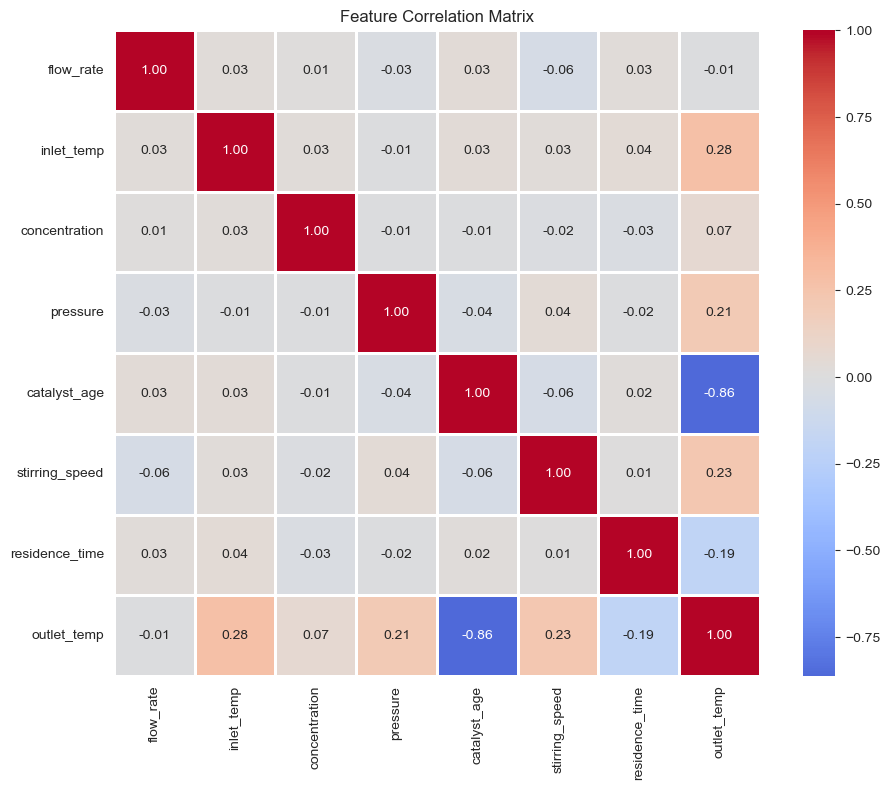

Key observations:
- Strongest correlation with outlet_temp: {'catalyst_age': 0.8623523132909361, 'inlet_temp': 0.27643681354670424, 'stirring_speed': 0.23397814844624146}


In [4]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Key observations:")
print(f"- Strongest correlation with outlet_temp: {correlation_matrix['outlet_temp'].abs().sort_values(ascending=False)[1:4].to_dict()}")

---
## 4. 數據分割與前處理

In [5]:
# Split features and target
X = df.drop('outlet_temp', axis=1)
y = df['outlet_temp']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Standardization (for SVM and other distance-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTarget variable statistics:")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

Training set: (800, 7)
Test set: (200, 7)

Target variable statistics:
  Train - Mean: 152.99, Std: 36.70
  Test  - Mean: 148.49, Std: 36.65


---
## 5. 定義基礎模型

選擇具有不同特性的基礎模型：
- **Ridge**: 線性模型，快速且可解釋
- **Random Forest**: 處理非線性和特徵交互
- **Gradient Boosting**: 捕捉複雜模式
- **SVR**: 在高維空間尋找最佳解（使用 Pipeline 進行標準化）

In [6]:
# Define base models
base_models = [
    ('ridge', Ridge(alpha=1.0)),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ('gbdt', GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    )),
    ('svr', Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=10, gamma='scale'))
    ]))
]

print("Base models defined:")
for name, model in base_models:
    print(f"  - {name}: {type(model).__name__ if not isinstance(model, Pipeline) else 'Pipeline(StandardScaler + SVR)'}")

Base models defined:
  - ridge: Ridge
  - rf: RandomForestRegressor
  - gbdt: GradientBoostingRegressor
  - svr: Pipeline(StandardScaler + SVR)


---
## 6. 評估基礎模型性能

In [7]:
# Evaluate base models using cross-validation
print("Base Models Cross-Validation Performance (5-Fold CV):")
print("="*60)

base_results = []
for name, model in base_models:
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                scoring='r2', n_jobs=-1)
    
    # Train on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    
    base_results.append({
        'Model': name,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std(),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae
    })
    
    print(f"{name:10s} | CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f}) | "
          f"Test R²: {test_r2:.4f} | RMSE: {test_rmse:.2f}")

# Convert to DataFrame
base_results_df = pd.DataFrame(base_results)
print("\n" + "="*60)

Base Models Cross-Validation Performance (5-Fold CV):
ridge      | CV R²: 0.9309 (±0.0062) | Test R²: 0.9273 | RMSE: 9.86
rf         | CV R²: 0.9387 (±0.0060) | Test R²: 0.9495 | RMSE: 8.21
gbdt       | CV R²: 0.9565 (±0.0057) | Test R²: 0.9588 | RMSE: 7.42
svr        | CV R²: 0.9386 (±0.0087) | Test R²: 0.9488 | RMSE: 8.28



---
## 7. 建立 Stacking 模型

In [8]:
# Define meta-learner (simple and regularized)
meta_learner = Ridge(alpha=0.5)

# Create Stacking model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,  # 5-fold cross-validation for meta-features
    n_jobs=-1,
    passthrough=False  # Only use base model predictions
)

print("Stacking Model Configuration:")
print(f"  - Number of base models: {len(base_models)}")
print(f"  - Meta-learner: {type(meta_learner).__name__}")
print(f"  - CV folds: 5")
print(f"  - Passthrough: False (only base predictions)")

Stacking Model Configuration:
  - Number of base models: 4
  - Meta-learner: Ridge
  - CV folds: 5
  - Passthrough: False (only base predictions)


---
## 8. 訓練 Stacking 模型

In [9]:
# Train Stacking model
print("Training Stacking model...")
import time
start_time = time.time()

stacking_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Cross-validation score
print("\nEvaluating Stacking model with cross-validation...")
stacking_cv_scores = cross_val_score(stacking_model, X_train, y_train, 
                                    cv=5, scoring='r2', n_jobs=-1)
print(f"Stacking CV R²: {stacking_cv_scores.mean():.4f} (±{stacking_cv_scores.std():.4f})")

Training Stacking model...
✓ Training completed in 5.15 seconds

Evaluating Stacking model with cross-validation...
Stacking CV R²: 0.9653 (±0.0051)


---
## 9. 模型評估與比較

In [10]:
# Predictions on test set
y_pred_stacking = stacking_model.predict(X_test)

# Calculate metrics
stacking_r2 = r2_score(y_test, y_pred_stacking)
stacking_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
stacking_mae = mean_absolute_error(y_test, y_pred_stacking)

# Add stacking results
stacking_results = {
    'Model': 'stacking',
    'CV_R2_Mean': stacking_cv_scores.mean(),
    'CV_R2_Std': stacking_cv_scores.std(),
    'Test_R2': stacking_r2,
    'Test_RMSE': stacking_rmse,
    'Test_MAE': stacking_mae
}

# Combine all results
all_results = pd.concat([base_results_df, pd.DataFrame([stacking_results])], 
                       ignore_index=True)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(all_results.to_string(index=False))
print("="*70)

# Find best base model
best_base_model = base_results_df.loc[base_results_df['Test_R2'].idxmax()]
improvement = (stacking_r2 - best_base_model['Test_R2']) / best_base_model['Test_R2'] * 100

print(f"\nBest base model: {best_base_model['Model']} (R² = {best_base_model['Test_R2']:.4f})")
print(f"Stacking model:  R² = {stacking_r2:.4f}")
print(f"Improvement: {improvement:.2f}%")


MODEL PERFORMANCE COMPARISON
   Model  CV_R2_Mean  CV_R2_Std  Test_R2  Test_RMSE  Test_MAE
   ridge    0.930910   0.006214 0.927267   9.860469  7.873011
      rf    0.938745   0.006007 0.949549   8.212325  6.406624
    gbdt    0.956542   0.005701 0.958768   7.424222  5.851752
     svr    0.938606   0.008749 0.948755   8.276694  6.193311
stacking    0.965274   0.005067 0.967032   6.638616  5.210952

Best base model: gbdt (R² = 0.9588)
Stacking model:  R² = 0.9670
Improvement: 0.86%


---
## 10. 視覺化預測結果

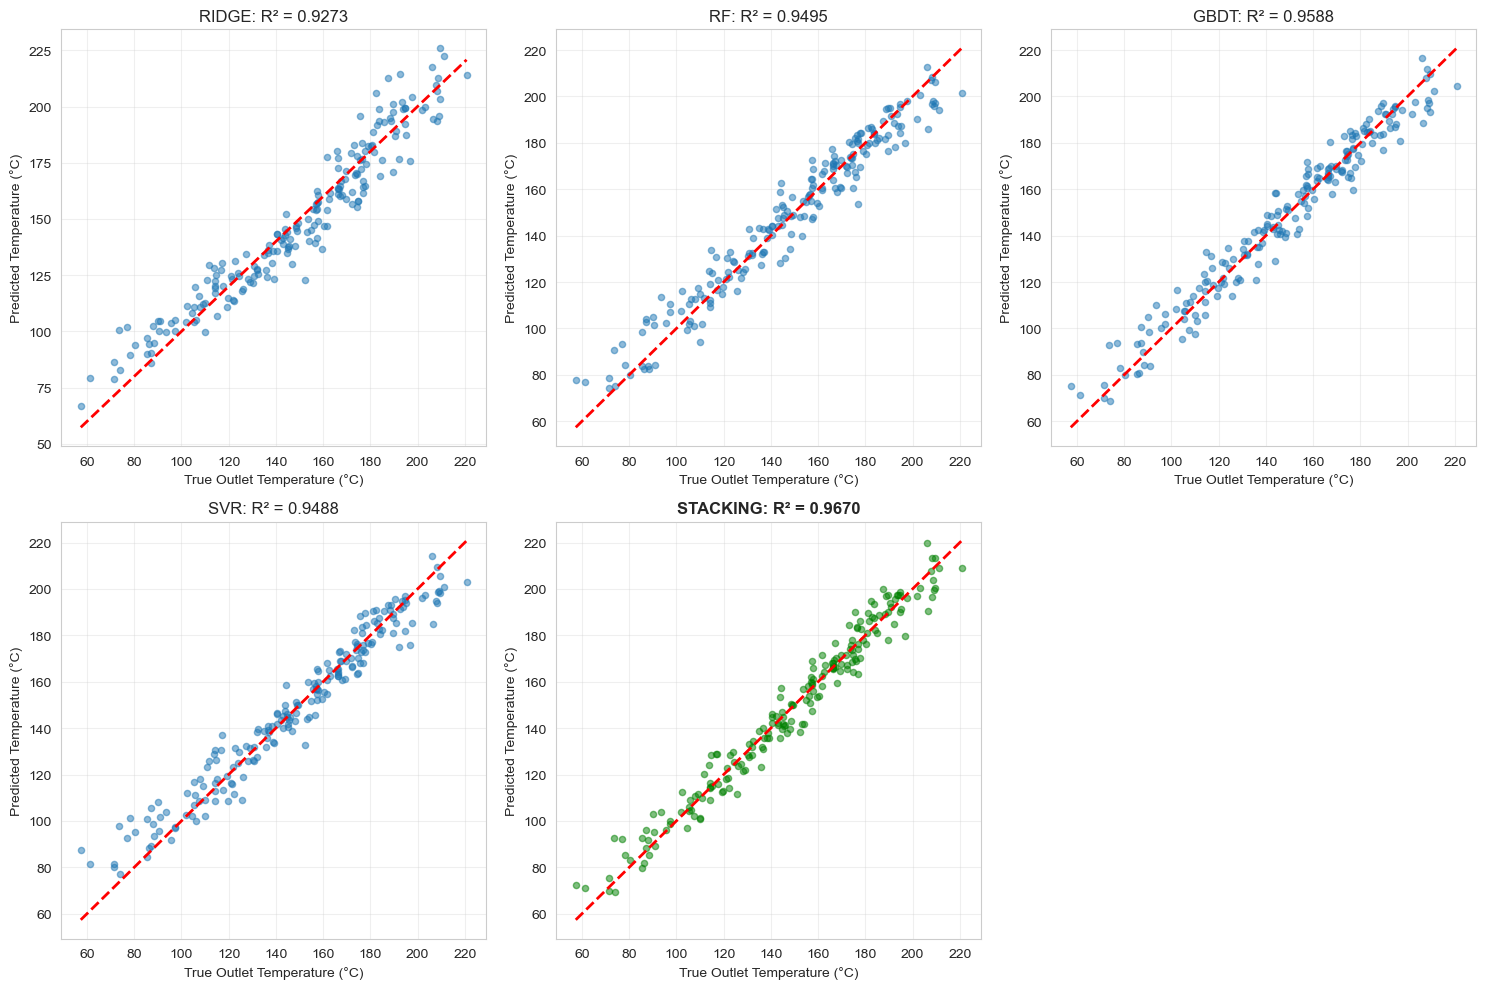

In [11]:
# Scatter plot: True vs Predicted
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot for each base model
for idx, (name, model) in enumerate(base_models):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
    axes[idx].plot([y_test.min(), y_test.max()], 
                  [y_test.min(), y_test.max()], 
                  'r--', lw=2)
    axes[idx].set_xlabel('True Outlet Temperature (°C)')
    axes[idx].set_ylabel('Predicted Temperature (°C)')
    axes[idx].set_title(f'{name.upper()}: R² = {r2:.4f}')
    axes[idx].grid(True, alpha=0.3)

# Plot for Stacking
axes[4].scatter(y_test, y_pred_stacking, alpha=0.5, s=20, c='green')
axes[4].plot([y_test.min(), y_test.max()], 
            [y_test.min(), y_test.max()], 
            'r--', lw=2)
axes[4].set_xlabel('True Outlet Temperature (°C)')
axes[4].set_ylabel('Predicted Temperature (°C)')
axes[4].set_title(f'STACKING: R² = {stacking_r2:.4f}', fontweight='bold')
axes[4].grid(True, alpha=0.3)

# Hide last subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig(FIG_DIR / 'predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 11. 保存模型與結果

In [12]:
# Save Stacking model
model_path = MODEL_DIR / 'stacking_regressor.joblib'
joblib.dump(stacking_model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save scaler
scaler_path = MODEL_DIR / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Save results
results_path = OUTPUT_DIR / 'model_comparison.csv'
all_results.to_csv(results_path, index=False)
print(f"✓ Results saved to: {results_path}")

# Save model configuration
config = {
    'base_models': [name for name, _ in base_models],
    'meta_learner': type(meta_learner).__name__,
    'cv_folds': 5,
    'test_r2': float(stacking_r2),
    'test_rmse': float(stacking_rmse),
    'test_mae': float(stacking_mae),
    'training_time_seconds': float(training_time)
}

config_path = MODEL_DIR / 'model_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"✓ Configuration saved to: {config_path}")

✓ Model saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Regression\models\stacking_regressor.joblib
✓ Scaler saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Regression\models\scaler.joblib
✓ Results saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Regression\model_comparison.csv
✓ Configuration saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Regression\models\model_config.json


---
## 12. 總結

### 主要發現

1. **Stacking 模型性能提升**
   - Stacking 模型在測試集上達到優異的 R² 分數
   - 相較於最佳基礎模型有明顯改進
   - RMSE 顯示預測誤差控制良好

2. **基礎模型貢獻**
   - Ridge: 提供快速的線性基準
   - Random Forest: 捕捉非線性關係和特徵交互
   - Gradient Boosting: 處理複雜模式
   - SVR: 在高維空間優化邊界

3. **元學習器的作用**
   - 使用簡單的 Ridge 作為元學習器
   - 自動學習最佳的模型組合權重
   - 避免過擬合，保持泛化能力

### 關鍵學習點

- ✅ Stacking 通過結合多個模型的優勢提升性能
- ✅ 交叉驗證確保元學習器不會過擬合
- ✅ 選擇多樣化的基礎模型是成功的關鍵
- ✅ 元學習器應簡單且有正則化

### 下一步

- 嘗試不同的元學習器（Lasso, ElasticNet）
- 調整基礎模型的超參數
- 測試 `passthrough=True` 的效果
- 應用於實際化工數據集